In [0]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.5 GB  | Proc size: 501.5 MB
GPU RAM Free: 14968MB | Used: 111MB | Util   1% | Total 15079MB


In [0]:
!ps ax | grep python

     23 ?        Sl     0:03 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
    415 ?        Ssl    0:02 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-ac9552e1-0a7f-4864-a298-4bee8359146d.json
    484 ?        S      0:00 /bin/bash -c ps ax | grep python
    486 ?        S      0:00 grep python


In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [0]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import string
import os
import glob
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Using TensorFlow backend.


'Tesla T4'

In [0]:
torch.cuda.empty_cache()

In [0]:
files = [f for f in glob.glob("*.csv")]

In [0]:
df_raw = pd.DataFrame()

for file in files:
 
  df = pd.read_csv(file)
  df['text'] = df['text'].apply(str)
  df_raw = pd.concat([df_raw , df], ignore_index=True)

df = df_raw.dropna()
df.head()

count_usefull = 0
for label in df['label_SALLY']:
    if label != 'U':
        count_usefull += 1
print("No. of Usefull Sentences: " + str(count_usefull))

No. of Usefull Sentences: 317


In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
def clean_text(line):
  line = line.lower()
  sentence = "[CLS] " + line + " [SEP]" 
  tokens = tokenizer.tokenize(sentence)
  tokens = [word for word in tokens if ((word.isalpha() or word=="[CLS]" or word == "[SEP]") and len(word)>1)]
  return tokens

In [0]:
def class_label_handler_binarysentenceclassifier(class_label):
  global count_usefull
  if class_label == 'U':
      count_usefull -= 1
      if count_usefull < 0:
          return np.NaN
  return class_label

In [1]:
df['text'] = df['text'].apply(clean_text)

df['Y'] = df['label_SALLY'].apply(class_label_handler_binarysentenceclassifier)
df = df.dropna()
df['Y'] = df['Y'].apply(lambda v: 0 if v == "U" else 1)
df.head()

NameError: ignored

In [0]:
len(df['Y'])

634

In [0]:
df = df.drop('label_SALLY', axis=1)
df = df.dropna()
df.head()

,text,line,start_pos,end_pos,file,Y
0,"[[CLS], apr, [SEP]]",0,0,14,cp_2004002.txt,0
1,"[[CLS], mr, senior, vice, president, and, prin...",2,0,148,cp_2004002.txt,0
2,"[[CLS], box, glen, rose, texas, subject, coma,...",2,148,475,cp_2004002.txt,0
3,"[[CLS], the, enclosed, integrated, inspection,...",2,475,645,cp_2004002.txt,0
4,"[[CLS], this, inspection, examined, activities...",2,645,837,cp_2004002.txt,0


In [0]:
# Splitting Training and Test
TRAIN_TEST_SPLIT = 0.8
msk = np.random.rand(len(df)) < TRAIN_TEST_SPLIT
df_train = df[msk]
df_test = df[~msk]

In [0]:
tokenized_texts = df_train['text']
labels = df_train.Y.values
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
# and pad the input
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4117991785208384


Epoch:  25%|██▌       | 1/4 [00:12<00:36, 12.16s/it]

Validation Accuracy: 0.9317434210526316
Train loss: 0.14213124439120292


Epoch:  50%|█████     | 2/4 [00:24<00:24, 12.24s/it]

Validation Accuracy: 0.9580592105263157
Train loss: 0.08574341076115767


Epoch:  75%|███████▌  | 3/4 [00:37<00:12, 12.37s/it]

Validation Accuracy: 0.9004934210526316
Train loss: 0.05956315640360117


Epoch: 100%|██████████| 4/4 [00:50<00:00, 12.54s/it]

Validation Accuracy: 0.9580592105263157


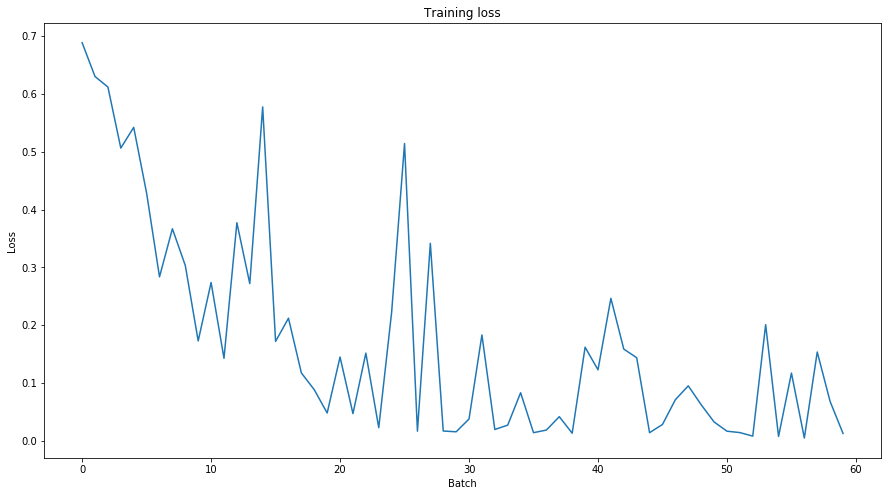

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Testing Section:

In [0]:
tokenized_texts = df_test['text']
labels = df_test.Y.values
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
# and pad the input
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print(predictions[0])
print(true_labels[0])

[[ 2.0443869  -2.9532592 ]
 [ 1.9376041  -2.8348048 ]
 [ 1.8453103  -2.6886532 ]
 [ 1.8994176  -2.7924664 ]
 [ 2.2613056  -3.2045457 ]
 [ 1.8427114  -2.785051  ]
 [ 2.810263   -3.166712  ]
 [ 2.913451   -3.4434342 ]
 [ 2.4124303  -2.71019   ]
 [ 2.9204154  -3.2401757 ]
 [ 2.6189847  -3.4464169 ]
 [ 1.6145868  -1.587189  ]
 [ 2.54949    -3.4842577 ]
 [ 3.0663116  -3.242465  ]
 [ 1.9026694  -2.7569916 ]
 [ 2.9839125  -3.4433105 ]
 [ 3.0663116  -3.242465  ]
 [ 1.75262    -2.5742    ]
 [ 2.9839125  -3.4433105 ]
 [ 2.8477771  -3.4809325 ]
 [ 2.5993323  -3.5099707 ]
 [ 3.0663116  -3.242465  ]
 [ 1.9315625  -2.7687976 ]
 [ 0.32508627 -0.8520339 ]
 [ 1.8104315  -2.5979733 ]
 [ 2.3604908  -3.354023  ]
 [ 2.8453603  -3.4850736 ]
 [ 2.3533232  -3.3404033 ]
 [ 1.8924481  -2.7477572 ]
 [ 2.9839125  -3.4433105 ]
 [ 1.9073094  -2.7204645 ]
 [ 2.9839125  -3.4433105 ]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))


Classification accuracy using BERT Fine Tuning: 88.91%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
df_test

,text,line,start_pos,end_pos,file,Y
2,"[[CLS], box, glen, rose, texas, subject, coma,...",2,148,475,cp_2004002.txt,0
4,"[[CLS], this, inspection, examined, activities...",2,645,837,cp_2004002.txt,0
5,"[[CLS], within, these, areas, the, inspection,...",2,837,1006,cp_2004002.txt,0
7,"[[CLS], in, accordance, with, cf, of, the, nr,...",2,1091,1378,cp_2004002.txt,0
8,"[[CLS], adams, is, accessible, from, the, nr, ...",2,1378,1501,cp_2004002.txt,0
...,...,...,...,...,...,...
9683,"[[CLS], inspection, scope, the, inspectors, ve...",100,49,425,ML061290031.txt,1
10033,"[[CLS], data, analysis, error, precursor, the,...",240,1066,1424,ML061290031.txt,1
10044,"[[CLS], specifically, questioning, attitude, w...",242,478,633,ML061290031.txt,1
10046,"[[CLS], the, first, area, is, low, level, of, ...",242,754,819,ML061290031.txt,1
